# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

### Изучение данных

Импортируем необходимые библиотеки:

In [430]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve 

Согласно инструкции, в нашем распоряжении датасет, который находится по пути "/datasets/Churn.csv". Импортируем его и выведем первые 10 строк.

In [431]:
df = pd.read_csv('/datasets/Churn.csv')
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


За признаки в датасете отвечают следующие столбцы:

- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

Столбец `Exited` является целевым признаком, и означает факт ухода клиента.

### Обработка данных

Видно, что в датасете присутствует столбец с индексом строки в данных. Загрузим датасет еще раз, но используем этот столбец в качестве индекса.

In [432]:
df = pd.read_csv('/datasets/Churn.csv', index_col='RowNumber')

Посмотрим информацию о датасете при помощи встроенной функции `info`.

In [433]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


Видно, что в столбце `Tenure` наблюдаются отсутствующие данные. Напомним, что этот столбец означает, сколько лет человек является клиентом банка.

Предположим, что если значение отсутствует, то человек только недавно начал пользоваться услугами банка, и одного года с начала пользования еще не прошло. Поэтому для него это значение и отсутсвует. Заменим такие данные на значение `0`.

In [434]:
df['Tenure'] = df['Tenure'].fillna(0)

Посмотрим информацию еще раз.

In [435]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


Видно, что от отсутствующих значений мы избавились.

Теперь удалим лишние столбцы, которые не должны повлиять на модель: идентификатор клиента `CustomerId` и его фамилия `Surname`, а также страна проживания `Geography`. 

In [436]:
df_model = df.drop(['CustomerId', 'Surname', 'Geography'], axis=1)

Посмотрим на данные.

In [437]:
df_model

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,
1,619,Female,42,2.0,0.00,1,1,1,101348.88,1
2,608,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,502,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,699,Female,39,1.0,0.00,2,0,0,93826.63,0
5,850,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...
9996,771,Male,39,5.0,0.00,2,1,0,96270.64,0
9997,516,Male,35,10.0,57369.61,1,1,1,101699.77,0
9998,709,Female,36,7.0,0.00,1,0,1,42085.58,1


Также предлагается превратить категориальный столбец `Gender` в числовую переменную.

In [438]:
df_model = pd.get_dummies(df_model, columns=['Gender'], drop_first=True)

Посмотрим на данные.

In [439]:
df_model

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male
RowNumber,,,,,,,,,,
1,619,42,2.0,0.00,1,1,1,101348.88,1,0
2,608,41,1.0,83807.86,1,0,1,112542.58,0,0
3,502,42,8.0,159660.80,3,1,0,113931.57,1,0
4,699,39,1.0,0.00,2,0,0,93826.63,0,0
5,850,43,2.0,125510.82,1,1,1,79084.10,0,0
...,...,...,...,...,...,...,...,...,...,...
9996,771,39,5.0,0.00,2,1,0,96270.64,0,1
9997,516,35,10.0,57369.61,1,1,1,101699.77,0,1
9998,709,36,7.0,0.00,1,0,1,42085.58,1,0


Видно, что действиительно добавился столбец, который в зависимости от пола клиента, обладает значением 1 или 0.

### Извлечение выборок

Теперь разделим наш датасет на тренировочную, валидационную и тестовую выборки.

Согласно предоставленной на курсе теории, в таком случае данные делят в отношении 3:1:1. То есть, 60 % данных уходит на обучающую выборку, и по 20 % на валидационную и тестовую. Для этого воспользуемся функцией `train_test_split` из библиотеки `sklearn`.

Сначала разделим датасет на обучающую выборку и валидационную с тестовой.

In [440]:
train, test_valid = train_test_split(df_model, train_size=0.6, random_state=123456789)

Теперь разобьем второй датасет на две выборки, валидационную и тестовую.

In [441]:
valid, test = train_test_split(test_valid, train_size=0.5, random_state=123456789)

Теперь разобьем все выборки на `features` и `target`:

- `features` будет представлять собой исходный датасет без целевого признака `Exited`.
- `target` - целевой признак `Exited`

Так как алгоритм в данном случае будет одинаков, предлагается написать для этого функцию.

In [442]:
def features_target(df):
    features = df.drop(['Exited'], axis=1)
    target = df['Exited']
    return features, target

Разделим все выборки, вызвав функцию для каждой из них.

In [443]:
train_features, train_target = features_target(train)
valid_features, valid_target = features_target(valid)
test_features, test_target = features_target(test)

Посмотрим размеры полученных выборок.

In [444]:
print(f'''Размеры исходного датасета: {df_model.shape}
Размеры тренировочной выборки: {train_features.shape}
Размеры валидационной выборки: {valid_features.shape}
Размеры тестовой выборки: {test_features.shape} 
''')

Размеры исходного датасета: (10000, 10)
Размеры тренировочной выборки: (6000, 9)
Размеры валидационной выборки: (2000, 9)
Размеры тестовой выборки: (2000, 9) 



Видно, что датасет был разеделен в соответствии с соотношением 3:1:1.

**Вывод:**

В данном пункте было проведено:
- Изучение исходных данных, в ходе которой исходный датасет был загружен и изучено его содержание.
- Обработка данных, в результате которой в столбце `Tenure` отсутствующие значения были заменены на 0. Также удалены столбцы, которые не должны влиять на работу модели (`CustomerId`, `Surname`, `Geography`). Столбец с категориальной переменной `Gender` был превращен прямым кодированием в числовой.
- Извлечение выборок, в результаты которой наш датасет был разделен на тренировочную, валидационную и тестовую выборки.

## Обучение модели без учёта дисбаланса

Сначала ознакомимся с балансом классов. Для этого посчитаем количество различных значений в столбце с целевым признаком.

In [445]:
train_target.value_counts(normalize=True)

0    0.800833
1    0.199167
Name: Exited, dtype: float64

Видно, что в данных действительно присутствует дисбаланс, так как значения разделены в соотношении 4:1.

Однако, все же попробуем обучить модель на данных с дисбалансом чтобы потом посмотреть, насколько сильно он влияет на качество модели.

### Дерево решений

Оценим в цикле accuracy (доли правильных ответов) модели дерева решений для валидационной выборки при различных значениях гиперпараметра, а именно, величины `max_depth` или **глубины дерева**. 

Затем построим график значения accuracy для разных значений глубины дерева.

In [446]:
depth_values = list(range(1,11))
accuracy = []
for depth in range(1,11):
    model = DecisionTreeClassifier(random_state=123456789, max_depth=depth)
    model.fit(train_features, train_target)
    predictions = model.predict(valid_features)
    accuracy.append(accuracy_score(valid_target, predictions))

Text(0, 0.5, 'Точность "accuracy"')

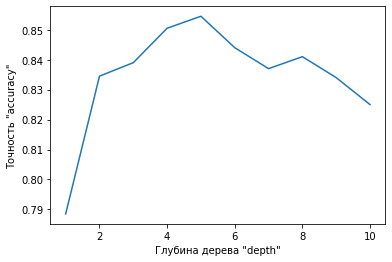

In [447]:
plt.plot(depth_values, accuracy)
plt.xlabel('Глубина дерева "depth"')
plt.ylabel('Точность "accuracy"')

Видно, что в нашем случае лучшая accuracy наблюдается для глубины дерева 5.

Посчитаем значение метрик precision, recall и F1 для этой глубины дерева.

In [448]:
model = DecisionTreeClassifier(random_state=123456789, max_depth=5)
model.fit(train_features, train_target)
predictions = model.predict(valid_features)
print(f'Accuracy: {accuracy_score(valid_target, predictions)}')
print(f'Recall: {recall_score(valid_target, predictions)}')
print(f'Precision: {precision_score(valid_target, predictions)}')
print(f'F1: {f1_score(valid_target, predictions)}')

Accuracy: 0.8545
Recall: 0.39952718676122934
Precision: 0.8203883495145631
F1: 0.5373608903020668


**Вывод:**
- Accuracy составила 0.8545.
- Модель смогла выявить 40% от всех фактов ухода клиентов из банка.
- Из тех предсказаний, которые модель отметила как положительные (человек ушел из банка), 82% предсказаний были верны.
- Мера F1 составила 0.537.

### Случайный лес

В данном случае на валидационной выборке будем оптимизировать параметр модели случайного леса n_estimators или количества деревьев в лесу. Значение оптимальной глубины леса возьмем из предыдущей модели.

Количество деревьев перебирать в диапазоне от 10 до 100 с шагом 10.

In [449]:
est_values = list(range(10, 101, 10))
accuracy = []
for estimators in range(10, 101, 10):
    model = RandomForestClassifier(random_state=123456789, n_estimators=estimators, max_depth=5)
    model.fit(train_features, train_target)
    predictions = model.predict(valid_features)
    accuracy.append(accuracy_score(valid_target, predictions))

Text(0, 0.5, 'Точность "accuracy"')

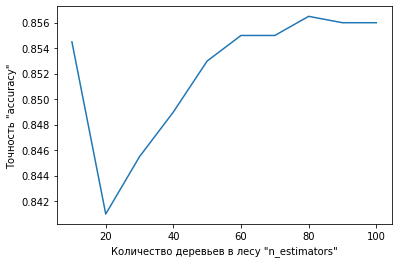

In [450]:
plt.plot(est_values, accuracy)
plt.xlabel('Количество деревьев в лесу "n_estimators"')
plt.ylabel('Точность "accuracy"')

Видно, что в нашем случае лучшая accuracy наблюдается для количества деревьев 80.

Посчитаем значение метрик precision, recall и F1 для этого количества деревьев.

In [451]:
model = RandomForestClassifier(random_state=123456789, n_estimators=80, max_depth=5)
model.fit(train_features, train_target)
predictions = model.predict(valid_features)
print(f'Accuracy: {accuracy_score(valid_target, predictions)}')
print(f'Recall: {recall_score(valid_target, predictions)}')
print(f'Precision: {precision_score(valid_target, predictions)}')
print(f'F1: {f1_score(valid_target, predictions)}')

Accuracy: 0.8565
Recall: 0.3617021276595745
Precision: 0.9
F1: 0.5160202360876898


**Вывод:**
- Accuracy составила 0.8565.
- Модель смогла выявить 36% от всех фактов ухода клиентов из банка.
- Из тех предсказаний, которые модель отметила как положительные (человек ушел из банка), 90% предсказаний были верны.
- Мера F1 составила 0.516.

### Логистическая регрессия

Посчитаем значение accuracy для модели логистической регрессии на валидационной выборке.

In [452]:
model = LogisticRegression(random_state=123456789, solver='liblinear')
model.fit(train_features, train_target)
predictions = model.predict(valid_features)

Посчитаем значение метрик accuracy, precision, recall и F1.

In [453]:
print(f'Accuracy: {accuracy_score(valid_target, predictions)}')
print(f'Recall: {recall_score(valid_target, predictions)}')
print(f'Precision: {precision_score(valid_target, predictions)}')
print(f'F1: {f1_score(valid_target, predictions)}')

Accuracy: 0.793
Recall: 0.06619385342789598
Precision: 0.5957446808510638
F1: 0.11914893617021277


Значение recall получилось очень малым, то есть модель смогла обнаружить всего около 7% факта ухода клиентов из банков. 

Воспользуемся встроенной функцией `roc_curve` и построим график значений False Positive Rate и True Positive Rate для разного порога классификации нашей модели. Это покажет нам, меняется ли значение recall при разных порогах классификации.

Также добавим на график прямую, отвечающую за кривую ROC для случайной модели.

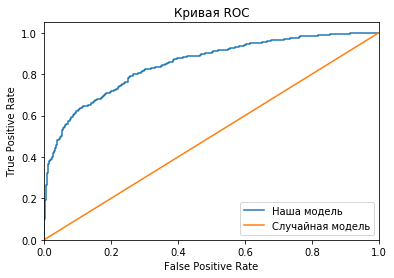

In [464]:
fpr, tpr, thresholds = roc_curve(valid_target, model.predict_proba(valid_features)[:,1]) 
plt.step(fpr, tpr, label="Наша модель")
plt.plot([0, 1], [0, 1], label="Случайная модель") 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC')
plt.legend()
plt.show() 

**Вывод:**
- Accuracy составила 0.793.
- Модель смогла выявить лишь 6.6% от всех фактов ухода клиентов из банка. Однако, если изменить порог классификации, то этот показатель можно значительно повысить. Однако, высокие значения этого параметра тоже плохи, так как модель может просто начать отвечать "да" во всех случаях.
- Из тех предсказаний, которые модель отметила как положительные (человек ушел из банка), 60% предсказаний были верны.
- Мера F1 составила 0.12.

## Борьба с дисбалансом

Для борьбы с дисбалансом предлагается стандартизировать признаки `CreditScore`, `Age`, `Tenure`, `EstimatedSalary`, чтобы привести все данные к примерно одному масштабу. Для этого воспользуемся встроенной функцией `StandardScaler` из библиотеки `sklearn`.

In [465]:
scaler = StandardScaler()
columns_to_scale = ['CreditScore', 'Age', 'Tenure', 'EstimatedSalary']
scaler.fit(df_model[columns_to_scale]) 
df_model[columns_to_scale] = scaler.transform(df_model[columns_to_scale])
df_model

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male
RowNumber,,,,,,,,,,
1,-0.326221,0.293517,-0.817441,0.00,1,1,1,0.021886,1,0
2,-0.440036,0.198164,-1.138838,83807.86,1,0,1,0.216534,0,0
3,-1.536794,0.293517,1.110941,159660.80,3,1,0,0.240687,1,0
4,0.501521,0.007457,-1.138838,0.00,2,0,0,-0.108918,0,0
5,2.063884,0.388871,-0.817441,125510.82,1,1,1,-0.365276,0,0
...,...,...,...,...,...,...,...,...,...,...
9996,1.246488,0.007457,0.146750,0.00,2,1,0,-0.066419,0,1
9997,-1.391939,-0.373958,1.753735,57369.61,1,1,1,0.027988,0,1
9998,0.604988,-0.278604,0.789544,0.00,1,0,1,-1.008643,1,0


### Проверка оптимальной модели

Для оптимизации будем использовать модель случайного леса с оптимальными параметрами из прошлого пункта. Но в этом случае сбалансируем вес каждой переменной, используя параметр `class_weight`. Затем посчитаем все метрики еще раз.

In [526]:
model = RandomForestClassifier(random_state=123456789, 
                               n_estimators=80, 
                               max_depth=5, 
                               class_weight='balanced')
model.fit(train_features, train_target)
predictions = model.predict(valid_features)
accuracy.append(accuracy_score(valid_target, predictions))

In [527]:
print(f'Accuracy: {accuracy_score(valid_target, predictions)}')
print(f'Recall: {recall_score(valid_target, predictions)}')
print(f'Precision: {precision_score(valid_target, predictions)}')
print(f'F1: {f1_score(valid_target, predictions)}')

Accuracy: 0.7985
Recall: 0.6855791962174941
Precision: 0.5178571428571429
F1: 0.5900305188199391


Видно, что по сравнению с несбалансированной моделью:
- Accuracy уменьшилась (0.8565 -> 0.7985)
- Recall увеличился почти в 2 раза (0.3617 -> 0.6856)
- Значение precision также уменьшилось (0.9 -> 0.5179)
- Мера F1 увеличилась (0.516 -> 0.59)

### ROC кривая

Теперь воспользуемся встроенной функцией `roc_curve` и построим график значений False Positive Rate и True Positive Rate для разного порога классификации. Также добавим на график прямую, отвечающую за кривую ROC для случайной модели.

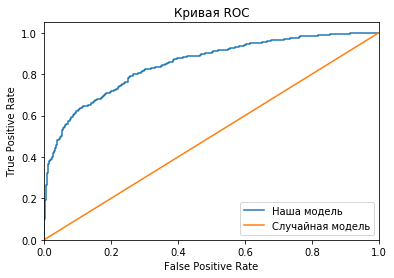

In [528]:
fpr, tpr, thresholds = roc_curve(valid_target, model.predict_proba(valid_features)[:,1]) 
plt.step(fpr, tpr, label="Наша модель")
plt.plot([0, 1], [0, 1], label="Случайная модель") 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC')
plt.legend()
plt.show() 

Видно, что в нашем случае модель дает предсказания лучше, чем случайная модель.

## Тестирование модели

Протестируем модель на тестовых данных и посчитаем все метрики.

In [529]:
predictions = model.predict(test_features)
print(f'Accuracy: {accuracy_score(test_target, predictions)}')
print(f'Recall: {recall_score(test_target, predictions)}')
print(f'Precision: {precision_score(test_target, predictions)}')
print(f'F1: {f1_score(test_target, predictions)}')

Accuracy: 0.7835
Recall: 0.7016706443914081
Precision: 0.4883720930232558
F1: 0.5759059745347698


Согласно условиям проекта, необходимо довести F1 до 0.59 на тестовых данных. Поэтому, модель необходимо оптимизировать. Попробуем поменять глубину леса и посмотрим, при какой глубине и количестве деревьев в лесу достигается максимальная метрика F1 на валидационной выборке.


In [562]:
best_model = None
best_result = 0
for depth in range(1, 11):
    for estimators in range(10, 101, 10):
        model = RandomForestClassifier(random_state=123456789, n_estimators=estimators, max_depth=depth)
        model.fit(train_features, train_target)
        predictions = model.predict(valid_features)
        results = accuracy_score(valid_target, predictions)
        if results > best_result:
            best_model = model
            best_result = results

In [563]:
print(f'''Наибольшее значение метрики accuracy в {best_result} в модели случайного леса достигается при глубине леса 
{best_model.max_depth} и количесте деревьев {best_model.n_estimators}''')

Наибольшее значение метрики accuracy в 0.862 в модели случайного леса достигается при глубине леса 
6 и количесте деревьев 30


Посчитаем F1 на тестовой выборке еще раз, используя другие параметры.

In [564]:
model = RandomForestClassifier(random_state=123456789, n_estimators=30, max_depth=6)
model.fit(train_features, train_target)
predictions = model.predict(test_features)
print(f'Accuracy: {accuracy_score(test_target, predictions)}')
print(f'Recall: {recall_score(test_target, predictions)}')
print(f'Precision: {precision_score(test_target, predictions)}')
print(f'F1: {f1_score(test_target, predictions)}')

Accuracy: 0.85
Recall: 0.3794749403341289
Precision: 0.7989949748743719
F1: 0.5145631067961165


Вторым вариантом улучшения предсказаний модели может быть изменение порога классификации предсказания, как положительного. Воспользуемся встроенной функцией `predict_proba` в библиотеке `sklearn`, которая рассчитывает вероятности положительного и негативного предсказаний. Будем считать показатель F1 для каждого порога классификации, и затем построим соответствующий график.

In [565]:
probabilities_one_valid = model.predict_proba(valid_features)[:,1]
threshold_list = list(np.arange(0, 1, 0.02))
f1 = []
for threshold in np.arange(0, 1, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1.append(f1_score(valid_target, predicted_valid))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


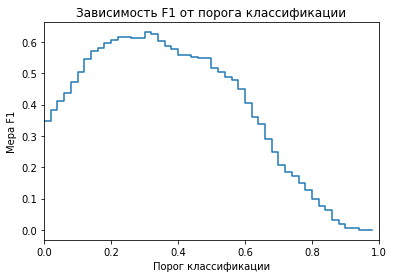

In [566]:
plt.step(threshold_list, f1)
plt.xlabel('Порог классификации')
plt.ylabel('Мера F1')
plt.xlim([0.0, 1.0])
plt.title('Зависимость F1 от порога классификации')
plt.show() 

Видно, что максимальная мера F1 достигается на валидационной выборке при пороге классификации 0.3. Посчитаем метрику F1 для тестовых данных еще раз, установив другой порог классификации.

In [569]:
probabilities_one_valid = model.predict_proba(test_features)[:,1]
threshold = 0.30
predicted_test = probabilities_one_valid > threshold
f1_score(test_target, predicted_test)

0.5979142526071842

**Вывод:**
Для того, чтобы достичь значения метрики F1 больше 0.59, необходимо использовать значение порога классификации равное 0.3.

##  Общий вывод 

В данном проекте была разработана модель, которая делает предсказания о том, уйдет ли клиент из банка "Бета-банк" на основе исторических данных об уходе клиентов из банков.

1. Было проведено изучение данных, с которыми мы впоследствии работали.
2. Была проведена обработка данных:
    - Заполнены отсутствующие значения
    - Удалены столбцы, которые не должны влиять на работу модели
    - Некоторые переменные переведены в числовые категориальные
    - Исходные данные были разделены на три выборки: обучающую, валидационную и тестовую в соотношении 3:1:1.
3. Были исследованы три модели без учета баланса классов (`DecisionTreeClassifier`, `RandomForestClassifier` и `LogisticRegression`). Рассчитаны метрики классификации моделей и определены оптимальные параметры на валидационной выборке.
4. Оптимальная модель `RandomForestClassifier` с количеством деревьев в лесу `n_estimators` 80 и глубиной леса `max_Depth` 5 была исследована с учетом баланса классов. Рассчитаны изменения метрик на валидационной выборке:
    - Accuracy уменьшилась (0.8565 -> 0.7985)
    - Recall увеличился почти в 2 раза (0.3617 -> 0.6856)
    - Значение precision также уменьшилось (0.9 -> 0.5179)
    - Мера F1 увеличилась (0.516 -> 0.59)
5. Была построена ROC кривая, которая показала, что наша модель работает лучше случайной модели.
6. Однако, на тестовых данных не удалось достичь необходимой метрики F1 = 0.59. Поэтому изменялся порог классификации на валидационной выборке и рассчитывались соответствующие значения метрики F1 на тестовой выборке. Определенный порог классификации для получения необходимого значения метрики F1 составил 0.3.